# LSTM Model

## Imports

In [1]:
!pip install --upgrade tensorflow

In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

## Step 1: Load data

In [3]:
ticker = 'MSFT'
with open(f'../DataInputs/Weekly-Closing-prices/{ticker}_Pricing/{ticker}_weekly_close.json', 'r') as file:
    data = json.load(file)

# Convert data to a sorted list of tuples (date, price)
sorted_data = sorted((pd.to_datetime(date), float(price)) for date, price in data.items())

# Separate dates and prices
dates, prices = zip(*sorted_data)


## Step 2: Preprocess data

In [4]:
# reshaping the array to 2D as required by the scaler
prices = np.array(prices).reshape(-1, 1)

# Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


## Step 3: Split the data

In [5]:

# Covid - 2020-03-13	2019-07-12 - April Stable	Drop -  2022-04-08

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assume dates and scaled_prices are already defined
# Convert dates list to pandas datetime for easier handling
dates_pd = pd.to_datetime(dates)

# Define your split date
split_date = pd.Timestamp('2019-07-12')

# Define your end date
end_date = pd.Timestamp('2019-10-05')  # End date for the dataset

# Find the index to start the split
split_start_index = np.where(dates_pd >= split_date)[0][0]

# Find the index to end the split, ensuring the end_date is included in the test set
split_end_index = np.where(dates_pd > end_date)[0][0]

print("Split Date Index:", split_start_index)
print("End Date Index:", split_end_index)

if split_end_index.size == 0:
    print(f"No matching end date found for {end_date}.")
elif split_start_index.size == 0:
    print(f"No matching split date found for {split_date}.")
elif split_end_index <= split_start_index:
    print("End index is not after the start index. No data in test set.")
else:
    print("Indices found. Proceeding with data split.")
    # Continue with the data split as normal


# Split scaled_prices using the found indices
train_data = scaled_prices[:split_start_index]

# Testing data goes from split_start_index to split_end_index
test_data = scaled_prices[split_start_index:split_end_index]

# Now your train_data and test_data are correctly split based on the dates

print(test_data.shape)
print(train_data.shape)


Split Date Index: 1026
End Date Index: 1039
Indices found. Proceeding with data split.
(13, 1)
(1026, 1)


## Step 4: Prepare data for LSTM

In [6]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]  # Corrected slicing for 1D array
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)



In [7]:

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1024, 1, 1)
X_test shape: (11, 1, 1)


In [8]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Step 5: Build the LSTM model

In [9]:

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 6: Train the model

In [10]:

model.fit(X_train, y_train, batch_size=1, epochs=20)


Epoch 1/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 2/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.4791e-05
Epoch 3/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4939e-05
Epoch 4/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.3097e-05
Epoch 5/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6505e-05
Epoch 6/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1874e-04
Epoch 7/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8592e-05
Epoch 8/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.5485e-05
Epoch 9/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5902e-05
Epoch 10/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4799e-05
Epoch 11/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.0064e-05
Epoch 12/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.5259e-05
Epoch 13/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3967e-05
Epoch 14/20
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/s

In [11]:

# Prepare the initial state from the end of the training set
last_train_batch = train_data[-time_step:]
last_train_batch = last_train_batch.reshape((1, time_step, 1))

In [12]:

# Generate predictions on the test data
test_predictions = []

# Start at the beginning of the test_data and iterate over it to make predictions
for i in range(len(test_data) - time_step):
    # Reshape the input for the model to make a prediction
    current_batch = test_data[i:(i + time_step), 0]
    current_batch = current_batch.reshape((1, time_step, 1))
    
    # Get the prediction (only one at each step) and store it
    test_pred = model.predict(current_batch)[0]
    test_predictions.append(test_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [13]:

# Flatten the test_predictions list and scale back to original values
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate the starting index for plotting test predictions
test_start_index = len(train_data) + time_step

print("test_start_index:", test_start_index)

# Ensure that we have the same number of dates as test predictions for plotting
plot_dates = dates[test_start_index:test_start_index + len(test_predictions)]


test_start_index: 1027


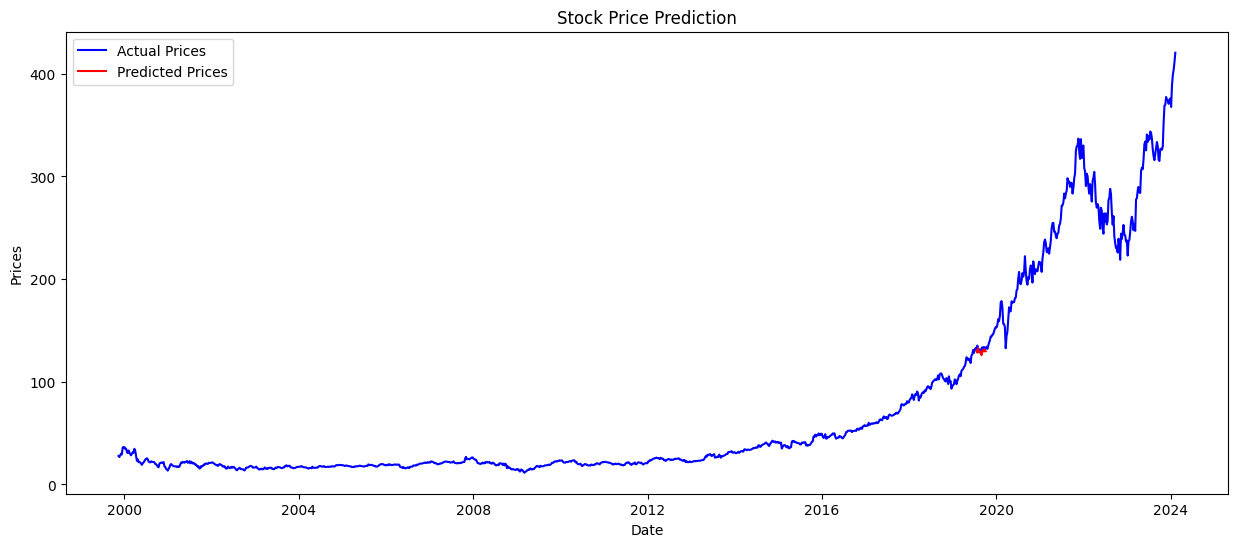

In [14]:
# After generating your predictions and actual prices

# Flatten the test_predictions if they're not already flat
test_predictions = np.array(test_predictions).reshape(-1)

# Generate a list of plot dates that matches the length of your test predictions
plot_dates = dates[test_start_index:test_start_index + len(test_predictions)]

# Now plot the data
plt.figure(figsize=(15, 6))

# Plot the entire dataset for actual prices
plt.plot(dates, prices, label='Actual Prices', color='blue')

# Plot the predicted prices
# Make sure plot_dates and test_predictions have the same length
plt.plot(plot_dates, test_predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()


## RMSE & MAE

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Since we have already scaled the test data and predicted data, we need to inverse the scaling to get meaningful error metrics
actual_test_prices = scaler.inverse_transform(test_data[time_step:])
predicted_test_prices = test_predictions

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_test_prices, predicted_test_prices))
mae = mean_absolute_error(actual_test_prices, predicted_test_prices)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')


Test RMSE: 3.4806060001678376
Test MAE: 2.711153757731118


## Evaluating on specific dates

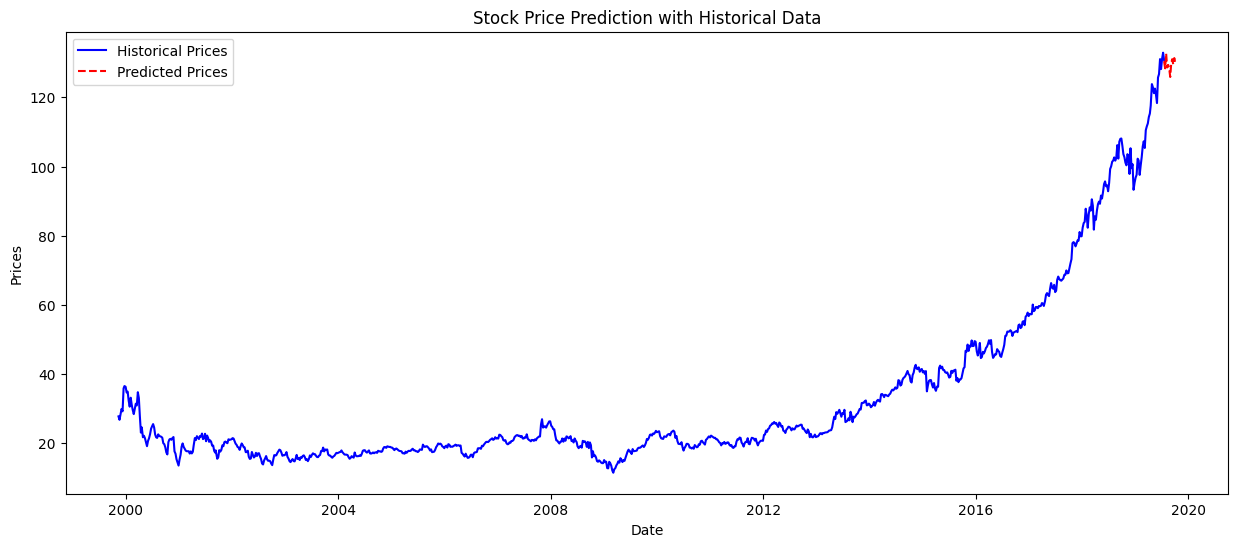

In [16]:
# We need to ensure that plot_dates is a list of pandas Timestamps for correct plotting.
# If plot_dates was not previously converted to Timestamps, you should convert it as follows:
plot_dates = pd.to_datetime(plot_dates)

# Plot the entire prediction period
plt.figure(figsize=(15, 6))

# Plot the actual historical data up to the end of the training data.
# The training data goes up to 'test_start_index', and we'll include the 'time_step' because it's used to generate the first prediction.
plt.plot(dates[:test_start_index+time_step], prices[:test_start_index+time_step], label='Historical Prices', color='blue')

# Now plot the prediction period.
# 'plot_dates' contains the dates corresponding to the prediction period, which comes after the historical data.
plt.plot(plot_dates, test_predictions, label='Predicted Prices', color='red', linestyle='--')

plt.title('Stock Price Prediction with Historical Data')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()


Saving results

In [17]:
import os
import json

# Define the directory path based on your ticker and event
output_dir = f'../outputs/{ticker}/stable'

# Ensure the directory exists; if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the full path for the JSON file
output_file_path = os.path.join(output_dir, f'LSTM_prediction.json')

# Convert your predictions to a list (if not already)
# Assuming test_predictions is your predictions array after inverse scaling
predictions_list = test_predictions.flatten().tolist()

# Create a dictionary to store dates as keys and predictions as values
prediction_dates = [date.strftime('%Y-%m-%d') for date in plot_dates]
predictions_dict = dict(zip(prediction_dates, predictions_list))

# Save the predictions to a JSON file
# with open(output_file_path, 'w') as file:
#     json.dump(predictions_dict, file, indent=4)

print(f'Predictions saved successfully to {output_file_path}')


Predictions saved successfully to ../outputs/MSFT/stable\LSTM_prediction.json
